# Introduction to Deep NLP models

In the previous lecture, we learned how to create a bag-of-words (BOW) model to create an intuitive understanding of the source text dataset. However, as we saw, the BOW model ignores location information of the word. Hence, "today it will rain" and "will it rain today" will have the same BOW vector repesentations. Additionally, we lose the semantic meaning of words and their usage in sentences. For example, "cars" and "automobiles" could be represented as two different models, such that "used cars for sale" and "purchase old automobiles" could create totally different vector representations, although they are quite similar in our human understanding. Finally, BOW models fail to understand, and often ignores, rarely used new words added to the vocabulary.

## Text classification with an RNN

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis. The tutorial is heavily based on [Tensorflow text classification](https://www.tensorflow.org/text/tutorials/text_classification_rnn) tutorial available online. We will explain the notebook in depth and discuss code as we go along.

## Setup

We will import the required packages here. Note that we are importing `tfds` here. Tensorflow datasets package has a dataset called IMDB Reviews. We will use this dataset to train a deep learning model for text classification. Here, given a review of a movie, we will predict whether the movie review is positive or negative.

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteG2RAS4/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteG2RAS4/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteG2RAS4/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I took a chance on "Hardcastle and McCormick" by purchasing the first season\'s worth (Canadian release) from Amazon. When I got it, I started with the pilot, and I was instantly hooked after that. I rated it 5 stars on Amazon, and I am rating it 10 stars here. It is just that good. What I liked about it were the opening and closing themes, and of course Stephen J. Cannell\'s logo at the end of each episode, but most of all, the relationship between the Judge and Mark as they worked together to crack each case. I was so hooked that I also purchased the second season as a companion, and I enjoyed it equally. If you do not have this excellent series on disc, I believe that you should purchase it and put it in your collection.'
 b'I show this film to university students in speech and media law because its lessons are timeless: Why speaking out against injustice is important and can bring about the changes sought by the oppressed. Why freedom of the press and freedom of speech a

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

From [Tensorflow TextVectorization documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization):

> This layer has basic options for managing text in a Keras model. It transforms a batch of strings (one example = one string) into either a list of token indices (one example = 1D tensor of integer token indices) or a dense representation (one example = 1D tensor of float values representing data about the example's tokens).

> If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

> The processing of each example contains the following steps:
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector of ints or a dense float vector.

Now, let us create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Short sentences are padded with a padding token in such a way that the length of the sentences are the same. Padding tokens doesn't affect the learning ability of the network as they are not considered towards the gradient updates. Any words in a new sentence that is not already in the vocabulary will be marked with an unknown token. After the padding and unknown tokens they're sorted by frequency: 

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 540,   4, ...,   0,   0,   0],
       [ 10, 120,  11, ...,   0,   0,   0],
       [414,   9,  14, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I took a chance on "Hardcastle and McCormick" by purchasing the first season\'s worth (Canadian release) from Amazon. When I got it, I started with the pilot, and I was instantly hooked after that. I rated it 5 stars on Amazon, and I am rating it 10 stars here. It is just that good. What I liked about it were the opening and closing themes, and of course Stephen J. Cannell\'s logo at the end of each episode, but most of all, the relationship between the Judge and Mark as they worked together to crack each case. I was so hooked that I also purchased the second season as a companion, and I enjoyed it equally. If you do not have this excellent series on disc, I believe that you should purchase it and put it in your collection.'
Round-trip:  i took a chance on [UNK] and [UNK] by [UNK] the first [UNK] worth [UNK] release from [UNK] when i got it i started with the [UNK] and i was [UNK] [UNK] after that i [UNK] it 5 stars on [UNK] and i am rating it 10 stars here it is just that

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.60218984]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01644581]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 107s 251ms/step - loss: 0.6559 - accuracy: 0.5511 - val_loss: 0.5648 - val_accuracy: 0.6344
Epoch 2/5
391/391 [==============================] - 94s 238ms/step - loss: 0.4638 - accuracy: 0.7692 - val_loss: 0.4122 - val_accuracy: 0.8135
Epoch 3/5
391/391 [==============================] - 96s 244ms/step - loss: 0.3734 - accuracy: 0.8349 - val_loss: 0.3759 - val_accuracy: 0.8458
Epoch 4/5
391/391 [==============================] - 96s 244ms/step - loss: 0.3385 - accuracy: 0.8536 - val_loss: 0.3445 - val_accuracy: 0.8500
Epoch 5/5
391/391 [==============================] - 95s 241ms/step - loss: 0.3234 - accuracy: 0.8608 - val_loss: 0.3493 - val_accuracy: 0.8318


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 49s 125ms/step - loss: 0.3401 - accuracy: 0.8370
Test Loss: 0.34010306000709534
Test Accuracy: 0.8370400071144104


(0.0, 0.6725123092532158)

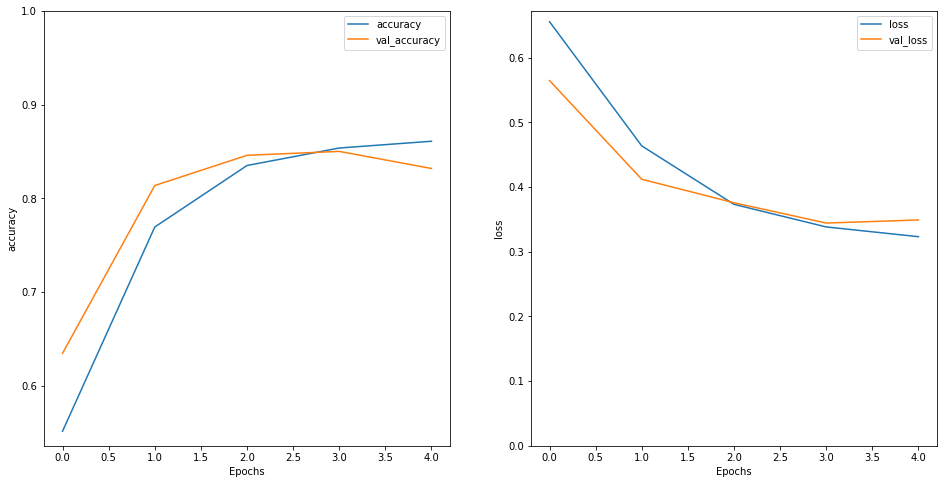

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

We can further improve the inference on new sentences by improving the way we present the predicted results.

In [ ]:
# prediction is >= 0.0 --> positive review
# else --> negative review

inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
    "Skip this movie.",
    "Don't waste your time.",
]

predicted_scores = model.predict(np.array(inputs))
predicted_labels = ["Positive" if x>=0.0 else "Negative" for x in predicted_scores]

for input, label in zip(inputs, predicted_labels):
  print("Question: ", input)
  print("Predicted label: ", label)

Question:  This is a fantastic movie.
Predicted label:  Positive
Question:  This is a bad movie.
Predicted label:  Negative
Question:  This movie was so bad that it was good.
Predicted label:  Negative
Question:  I will never say yes to watching this movie.
Predicted label:  Negative
Question:  Skip this movie.
Predicted label:  Negative
Question:  Don't waste your time.
Predicted label:  Negative


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 198s 461ms/step - loss: 0.6230 - accuracy: 0.6063 - val_loss: 0.4741 - val_accuracy: 0.8047
Epoch 2/5
391/391 [==============================] - 173s 440ms/step - loss: 0.4187 - accuracy: 0.8202 - val_loss: 0.3651 - val_accuracy: 0.8328
Epoch 3/5
391/391 [==============================] - 171s 436ms/step - loss: 0.3532 - accuracy: 0.8526 - val_loss: 0.3405 - val_accuracy: 0.8411
Epoch 4/5
391/391 [==============================] - 170s 433ms/step - loss: 0.3297 - accuracy: 0.8616 - val_loss: 0.3270 - val_accuracy: 0.8526
Epoch 5/5
391/391 [==============================] - 171s 436ms/step - loss: 0.3208 - accuracy: 0.8660 - val_loss: 0.3214 - val_accuracy: 0.8615


In [ ]:
test_loss_2, test_acc_2 = model_2.evaluate(test_dataset)

print('Test Loss:', test_loss_2)
print('Test Accuracy:', test_acc_2)

391/391 [==============================] - 87s 221ms/step - loss: 0.3182 - accuracy: 0.8625
Test Loss: 0.3182242512702942
Test Accuracy: 0.8625199794769287


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions_2 = model_2.predict(np.array([sample_text]))
print(predictions_2)

[[-1.172566]]


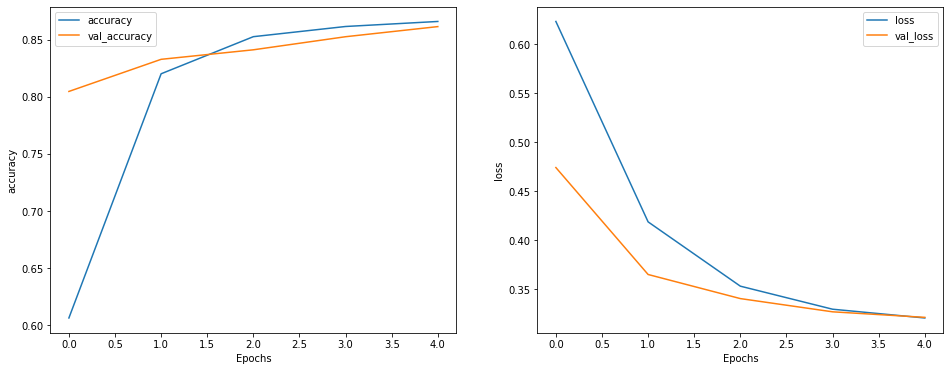

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_2, 'loss')

In [ ]:
# 0 --> negative review
# 1 --> positive review
inputs = [
    "This is a fantastic movie.",
    "This is a bad movie.",
    "This movie was so bad that it was good.",
    "I will never say yes to watching this movie.",
    "Skip this movie.",
    "Don't waste your time.",
]

predicted_scores_2 = model_2.predict(inputs)
predicted_labels_2 = ["Positive" if x>=0.0 else "Negative" for x in predicted_scores_2]

for input, label in zip(inputs, predicted_labels_2):
  print("Question: ", input)
  print("Predicted label: ", label)

Question:  This is a fantastic movie.
Predicted label:  Positive
Question:  This is a bad movie.
Predicted label:  Negative
Question:  This movie was so bad that it was good.
Predicted label:  Negative
Question:  I will never say yes to watching this movie.
Predicted label:  Positive
Question:  Skip this movie.
Predicted label:  Positive
Question:  Don't waste your time.
Predicted label:  Negative
